In [1]:
from pneumonia_dnn.dataset import update_dataset_from_metadata, create_dataset, DatasetClassifier
from pneumonia_dnn.project import create_project
import shutil
from pneumonia_dnn.project import apply_augmentations
from pneumonia_dnn.models.cnn import run_cnn
import matplotlib.pyplot as plt
from keras import backend
import PIL.Image
import os
import random
import json
from sklearn.metrics import ConfusionMatrixDisplay

def plot_history(history, item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

def display_random_images(folder_path: str, num_images: int=10):
    if not os.path.exists(folder_path):
        print("The specified folder does not exist.")
        return

    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

    if not files:
        print("No images found in the specified folder.")
        return

    selected_files = random.sample(files, min(num_images, len(files)))

    num_cols = int(num_images**0.5)
    num_rows = (num_images + num_cols - 1) // num_cols  # Ensure all images fit in the grid

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

    axs = axs.ravel() if num_images > 1 else [axs]

    for ax, file_path in zip(axs, selected_files):
        img = PIL.Image.open(file_path)
        ax.imshow(img)
        ax.axis('off')  # Hide axes

    # If there are any empty subplots, turn off their axes
    for ax in axs[len(selected_files):]:
        ax.axis('off')

    plt.show()

def plot_past_history(project_name: str, item):
    folder_path = f"projects/{project_name}/train_sessions/cnn"
    folders = os.listdir(folder_path)

    for folder in folders:
        with open(f"{folder_path}/{folder}/history.json", "r") as json_file:
            training_history = json.load(json_file)
            plt.plot(training_history[item], label=folder)

    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation sessions {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

epochs = 5
batch_size= 32


2024-04-26 22:25:02.079878: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 22:25:02.126396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 22:25:02.126424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 22:25:02.127580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 22:25:02.135111: I tensorflow/core/platform/cpu_feature_guar

# Dataset Creation

In [3]:
shutil.rmtree("datasets/demo_pneumonia_binary_classification", ignore_errors=True)

create_dataset("demo_pneumonia_binary_classification", "Chest X-Rays used for binary classification of pneumonia")

# Add data from Coronahack-chest-xray dataset
# source: https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset
update_dataset_from_metadata(
                        "demo_pneumonia_binary_classification",
                        "praveengovi/coronahack-chest-xraydataset",
                        "https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset",
                        "Chest_xray_Corona_Metadata.csv",
                        label_column="Label",
                        labels=[
                            DatasetClassifier("pneumonia", "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset", "Pnemonia", True),
                            DatasetClassifier("nonpneumonia",  "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset", "Normal", True)
                        ],
                        image_column="X_ray_image_name",
                        folder_column="Dataset_type",
                        folder_to_lower=True,
                        download_path="downloads",
                        dataset_path="datasets" )

# Add data from the Sampl NIH Dataset
# source: https://www.kaggle.com/datasets/nih-chest-xrays/sample
update_dataset_from_metadata(
                        "demo_pneumonia_binary_classification",
                        "sample",
                        "https://www.kaggle.com/datasets/nih-chest-xrays/sample",
                        "sample_labels.csv",
                        label_column="Finding Labels",
                        labels=[
                            DatasetClassifier("pneumonia", "sample/images", "Pneumonia", True),
                            DatasetClassifier("nonpneumonia",  "sample/images", "Pneumonia", False)
                        ],
                        image_column="Image Index",
                        folder_column=None,
                        folder_to_lower=True,
                        download_path="downloads",
                        dataset_path="datasets" )

/home/ubuntu/workspace/Pneumonia-DNN/pneumonia_dnn/dataset.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df[image_column] = (


ValueError: not enough values to unpack (expected 3, got 2)

# Create Project

In [14]:
shutil.rmtree("projects/demo_binary_classification", ignore_errors=True)
binary_classification_project = create_project("demo_binary_classification", "demo_pneumonia_binary_classification", 256, 256, 3, None, 0.7, 32, None)
seed = binary_classification_project["seed"]
random.seed(seed)

binary_classification_project

Processing train for label pneumonia:  25%|██▌       | 755/3010 [00:00<00:00, 7546.95it/s]

Processing test for label nonpneumonia: 100%|██████████| 1290/1290 [00:01<00:00, 668.98it/s]


{'name': 'demo_binary_classification',
 'max_images': 8600,
 'total_train': 6020,
 'total_test': 2580,
 'train_counts': {'pneumonia': 3010, 'nonpneumonia': 3010},
 'test_counts': {'pneumonia': 1290, 'nonpneumonia': 1290},
 'training_path': 'projects/demo_binary_classification/dataset/train',
 'testing_path': 'projects/demo_binary_classification/dataset/test',
 'seed': 5,
 'image_width': 256,
 'image_height': 256,
 'image_channels': 3,
 'labels': ['pneumonia', 'nonpneumonia']}

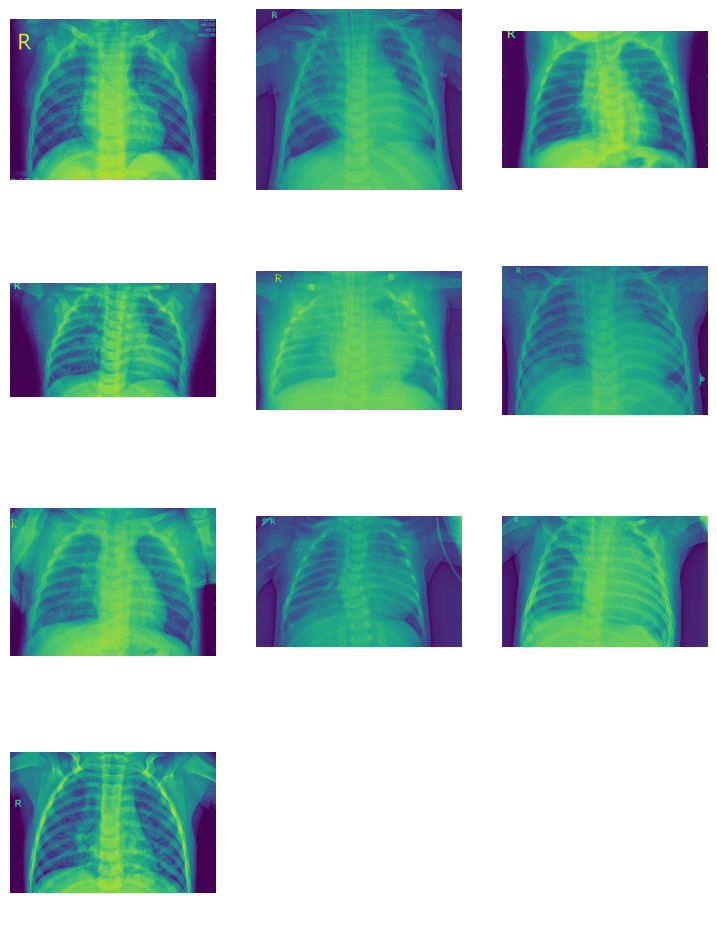

In [15]:
display_random_images('projects/demo_binary_classification/dataset/train/pneumonia/')

In [16]:
apply_augmentations("demo_binary_classification", 0.2, 0.2, True, True, 0.02)

In [20]:
backend.clear_session()
cnn_model, cnn_history, cnn_predictions, cnn_confusion_matrix_data, cnn_loss, cnn_accuracy = run_cnn("demo_binary_classification", epochs=epochs, batch_size=batch_size, use_adam_optimizer=False)
plot_history(cnn_history, "loss")
plot_history(cnn_history, "binary_accuracy")
backend.clear_session()
cnn_model.summary()

Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.
Epoch 1/5
Epoch 2/5


In [18]:
print(f"Loss - {cnn_loss}. Accuracy - {cnn_accuracy}")

Loss - 0.21073399484157562. Accuracy - 0.9263566136360168


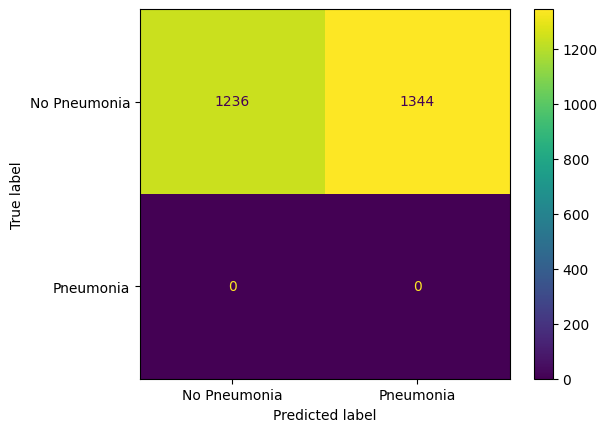

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_confusion_matrix_data, display_labels=['No Pneumonia', 'Pneumonia'])
disp.plot()
plt.show()

Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
81/81 [==============================] - 5s 59ms/step - loss: 0.1705 - binary_accuracy: 0.9376


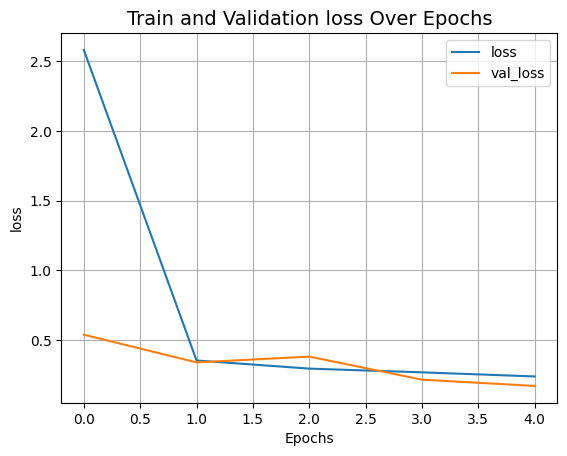

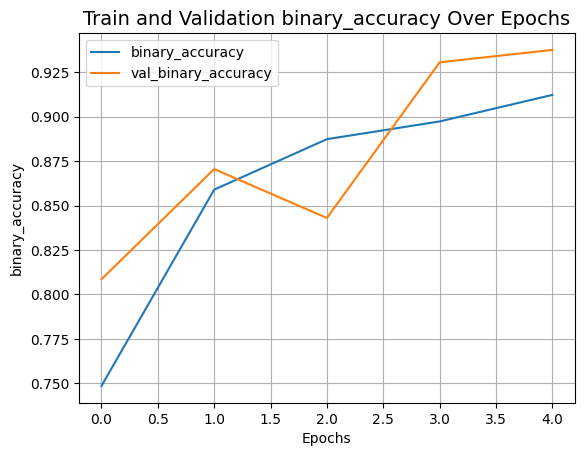

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       7         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0     

In [9]:
backend.clear_session()
cnn_model, cnn_history, cnn_predictions, cnn_confusion_matrix_data, cnn_loss, cnn_accuracy = run_cnn("demo_binary_classification", epochs=epochs, batch_size=batch_size, cnn_neurons=[16,32,64,128,512], use_adam_optimizer=False)
plot_history(cnn_history, "loss")
plot_history(cnn_history, "binary_accuracy")
backend.clear_session()
cnn_model.summary()

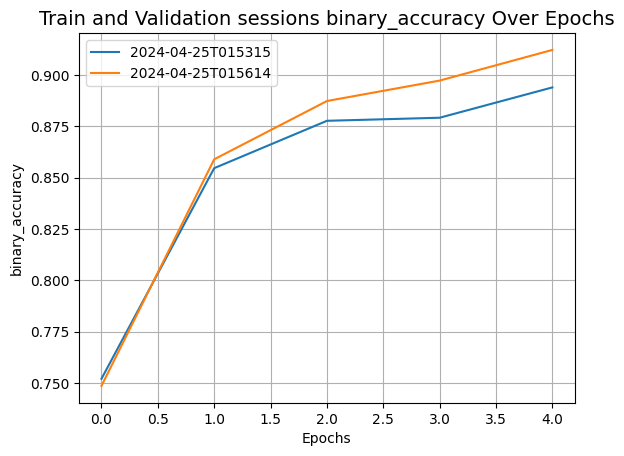

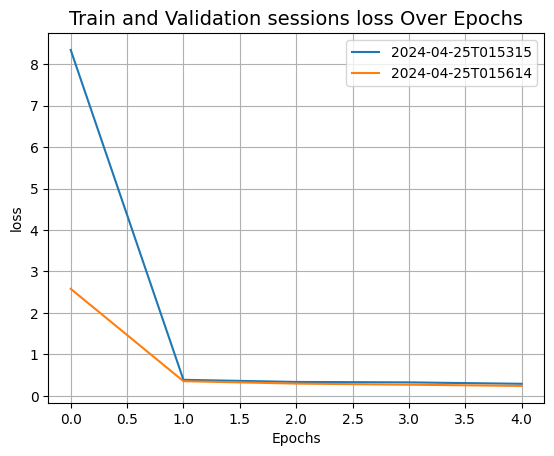

In [11]:
plot_past_history("demo_binary_classification", "binary_accuracy")
plot_past_history("demo_binary_classification", "loss")

Found 6020 files belonging to 2 classes.
Found 2580 files belonging to 2 classes.
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
81/81 [==============================] - 5s 59ms/step - loss: 0.2472 - binary_accuracy: 0.9264


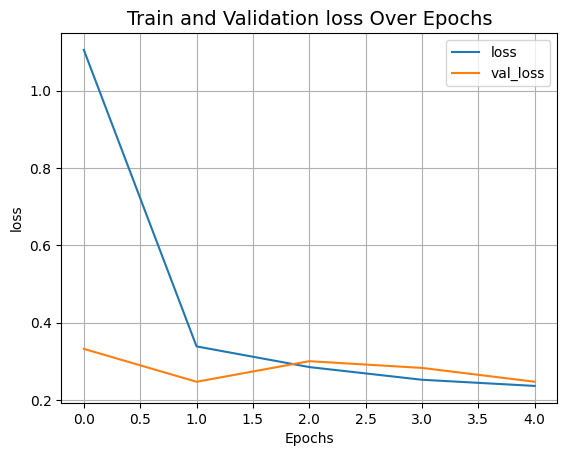

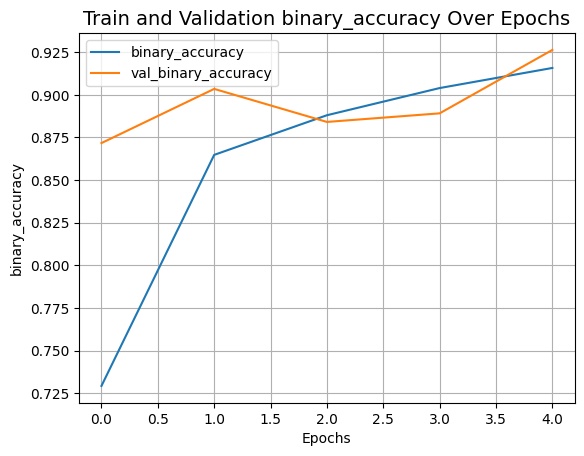

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       7         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0     

In [12]:
backend.clear_session()
cnn_model, cnn_history, cnn_predictions, cnn_confusion_matrix_data, cnn_loss, cnn_accuracy = run_cnn("demo_binary_classification", epochs=epochs, batch_size=batch_size, cnn_neurons=[16,32,64,128,512,1024], dense_layer_neurons=1024, use_adam_optimizer=False)
plot_history(cnn_history, "loss")
plot_history(cnn_history, "binary_accuracy")
backend.clear_session()
cnn_model.summary()

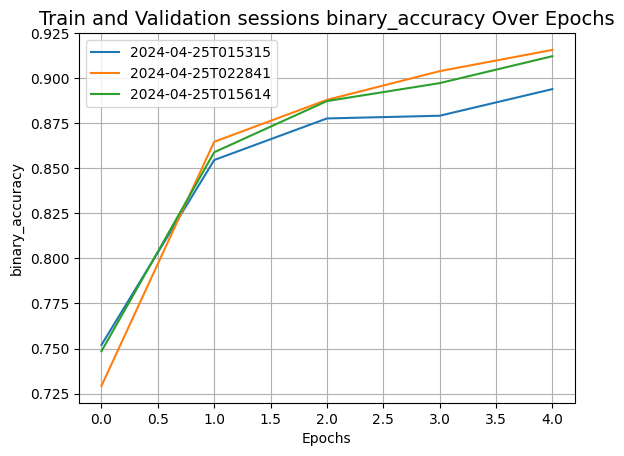

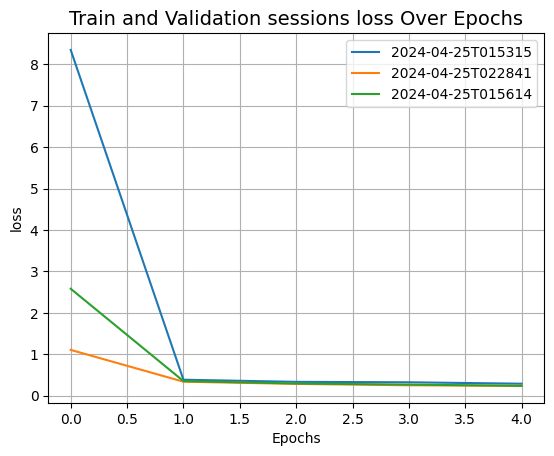

In [13]:
plot_past_history("demo_binary_classification", "binary_accuracy")
plot_past_history("demo_binary_classification", "loss")